In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

# %matplotlib notebook

import sys
sys.path.append("ELPH/")
sys.path.append("derrom/")
sys.path.append("utils/")

import derrom

In [2]:
trajectories = derrom.utils.load_trajectories(filename='../trajectories_n_kmax=200.npz')

trajectories = trajectories[:29:1]

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)

29 loaded with n_kmax = 200


In [3]:
import ELPH

system = ELPH.ELPH(kmax=2.0,n_kmax=n_kmax)


import fermi_fit

dk = 2./n_kmax

get_dispersion = system.electron_dispersion
get_DOS = system.electron_DOS

get_k = system.get_k

ks = get_k(dk,np.arange(n_kmax))
DOS = get_DOS(ks)
ens = get_dispersion(ks)

# print(DOS.shape, ens.shape)

fermi_fitter = fermi_fit.fermi_fit(DOS,ens,ELPH.kB)

In [4]:
Temps = []

for r,run in enumerate(trajectories):
    print('run: ', r)
    Temp_ar = np.zeros(run.shape[0])
    for k in range(run.shape[0]):
        mu,Temp,steps = fermi_fitter.fit(run[k], 0.1, 1000, False)
        Temp_ar[k] = Temp
        
    Temps.append(Temp_ar)

run:  0
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
run:  7
run:  8
run:  9
run:  10
run:  11
run:  12
run:  13
run:  14
run:  15
run:  16
run:  17
run:  18
run:  19
run:  20
run:  21
run:  22
run:  23
run:  24
run:  25
run:  26
run:  27
run:  28


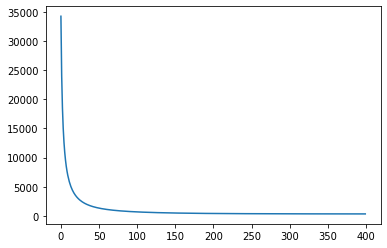

In [5]:
plt.plot(Temps[9])
plt.show()

In [6]:
dim_reducer = derrom.dim_reducers.SVD()
scaler = derrom.scalers.standardize_scaler(1.0)
transformer = derrom.transformers.ELM_features(ELM_nodes=1000)
optimizer = derrom.optimizers.ridge(alpha=10.**-3)

model = derrom.derrom(trajectories, Temps, rdim=15, DE_l=1, intercept=True, full_hist=False, 
                      optimizer=optimizer,
                      scaler=scaler,
                      dim_reducer=dim_reducer,
                      NL_transformer=transformer)

model.train()

model.print_status()

full_hist:  False
intercept:  True
standardize:  True
rdim:  15
DE_l:  1
train shape:  (11600, 1016)
target shape:  (11600,)
weights shape:  (1016,)


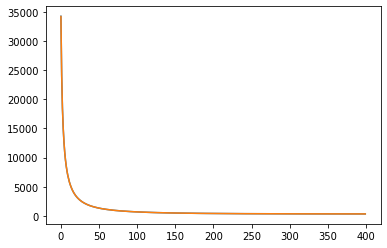

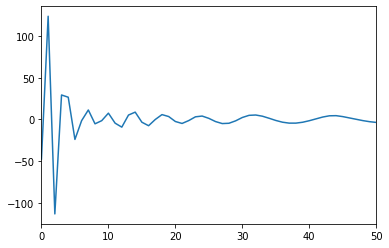

9.210957410389419
9.210957410389419
9.210957410389419


In [8]:
ind = 9

test_trajectory = trajectories[ind]
truth = Temps[ind].reshape((-1,1))

pred = model.predict(test_trajectory)


plt.plot(truth)
plt.plot(pred)
# plt.xlim(0,10)
plt.show()

plt.plot(pred-truth)
plt.xlim(0,50)
plt.show()


print( model.get_error(test_trajectory,truth,pred,norm='rms') ) 
print( model.get_error(test_trajectory,truth,norm='rms') ) 
print( model.get_error(truth=truth, pred=pred, norm='rms') ) 